In [26]:
import pickle
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import torch

from policy import DPAgent
from simulation import Simulator, CustomerGenerator
from hazard_models import ExponentialHazard
from utility_learner import ProjectedVolumeLearner, diam
from degradation_learner import DegradationLearner

from utils import unit_ball_rejection_sample, correct_signs
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import logging
logging.basicConfig(level=logging.INFO)

np.set_printoptions(suppress=True)

In [27]:
# --- 2. Define Sampling Functions ---
# def context_sampler() -> np.ndarray:
#     """Samples a customer's context vector from a uniform distribution."""
#     return np.random.uniform(low=0.0, high=1.0, size=D)

def context_sampler() -> np.ndarray:
    """Samples a customer's context vector uniformly from the unit ball."""
    return np.abs(unit_ball_rejection_sample(D))

def rental_sampler() -> float:
    """Samples a customer's desired rental duration from an exponential distribution."""
    return np.random.exponential(scale=10.0)

def interarrival_sampler() -> float:
    """Samples the time until the next customer arrives."""
    return np.random.exponential(scale=5.0)

In [28]:
# --- 1. Simulation Configuration ---
D = 4                                  # Dimension of context vectors
LAMBDA_VAL = 0.001                     # Baseline hazard constant
NUM_CUSTOMERS = 20000                   # Total number of customers to simulate, i.e. T

# Set a random seed for reproducibility
np.random.seed(41)

# Ground truth vectors
THETA_TRUE = np.array([0.5, 0.2, 0.4, 0.3])#$, 0.4])    # For degradation
UTILITY_TRUE = np.array([0.12450167, 0.40850869, 0.43930126, 0.71356037])

# context_sampler()  # For customer's willingness to pay

# --- Machine's Pricing Vector 'r' ---
# This is a fallback pricing vector, when we don't feed u_hat to calculate_price
PRICING_R = np.zeros(D)

In [29]:
usage_exp_hazard_model = ExponentialHazard(lambda_val=LAMBDA_VAL)
# spontaneous_exp_hazard_model = None # ExponentialHazard(lambda_val=0.01)

customer_gen = CustomerGenerator(
    d=D,
    context_sampler=context_sampler,
    rental_sampler=rental_sampler,
    interarrival_sampler=interarrival_sampler
)

centroid_params = {
    # 'num_samples': 2000,
    # 'thin': None,
    # 'burn_in': 500 * D ** 2,
    # 'tol': 1e-4,
    # 'rho_target': 0.01
}

termination_rule = lambda diameter: diameter < 0.0001  # Example custom termination rule

projected_volume_learner = ProjectedVolumeLearner(
    T=NUM_CUSTOMERS, 
    d=D, 
    centroid_params=centroid_params,
    incentive_constant=1.1,
    termination_rule=termination_rule,
)

mdp_params = {
    'replacement_cost': 1.5,   # Cost to replace the machine
    'failure_cost': 0.75,      # Additional penalty for in-service failure
    'holding_cost_rate': 0.02,   # Cost per unit of idle time
    'gamma': 0.99,             # Discount factor
    'learning_rate': 1e-3,      # Learning rate for the Adam optimizer
    'target_update_freq': 10    # How often to update the target network (in iterations)
}

training_hyperparams = {
    'num_iterations': 50, # Number of training iterations per policy update
    'dataset_size': 50000,      # Number of transitions to generate for the offline dataset
    'batch_size': 2048           # Batch size for training
}

policy_params = {
    'type': 'softmax',
    'tau': 1.0,
    'epsilon': 0.1,
}

# Instantiate the Simulator with the new parameters
simulator = Simulator(
    d=D,
    T=NUM_CUSTOMERS,
    
    theta_true=THETA_TRUE,
    utility_true=UTILITY_TRUE,
    pricing_r=PRICING_R,
    
    usage_hazard_model=usage_exp_hazard_model,
    customer_generator=customer_gen,
    projected_volume_learner=projected_volume_learner,  # Use default ProjectedVolumeLearner
    
    mdp_params=mdp_params,
    training_hyperparams=training_hyperparams,
    policy_params=policy_params,
    policy_update_threshold=5,
    time_normalize=True,
)

In [31]:
# simulator.projected_volume_learner.is_terminated = True
simulation_data = simulator.run(num_customers=NUM_CUSTOMERS)
degradation_df = pd.DataFrame(simulator.degradation_history)
simulation_df = pd.DataFrame(simulator.history)

INFO:root:Starting simulation for 20000 customers...
  0%|          | 46/20000 [16:07<188:20:27, 33.98s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 47: Diameter: 0.0006
  0%|          | 48/20000 [17:18<192:59:27, 34.82s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 49: Diameter: 0.0002
  0%|          | 49/20000 [17:53<193:43:37, 34.96s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 50: Diameter: 0.0004
  0%|          | 50/20000 [18:29<195:24:54, 35.26s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 51: Diameter: 0.0002
  0%|          | 51/20000 [19:09<202:25:38, 36.53s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 52: Diameter: 0.0002
  0%|          | 52/20000 [19:49<208:55:42, 37.71s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 53: Diameter: 0.0001
  0%|      

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  1.79176D+00    |proj g|=  1.00000D+00

At iterate    1    f=  4.89305D-02    |proj g|=  4.29010D-02

At iterate    2    f=  4.10146D-02    |proj g|=  2.48911D-02

At iterate    3    f=  3.68035D-02    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      5      6     0     4   0.000D+00   3.680D-02
  F =   3.6803478648273824E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Using de

100%|██████████| 50000/50000 [00:21<00:00, 2345.28it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 2.5282 | Avg Q-Value: 0.05
INFO:root:Iter 2/50 | Loss: 2.4871 | Avg Q-Value: -0.04
INFO:root:Iter 3/50 | Loss: 2.4116 | Avg Q-Value: -0.08
INFO:root:Iter 4/50 | Loss: 2.3560 | Avg Q-Value: -0.09
INFO:root:Iter 5/50 | Loss: 2.3425 | Avg Q-Value: -0.05
INFO:root:Iter 6/50 | Loss: 2.3478 | Avg Q-Value: -0.04
INFO:root:Iter 7/50 | Loss: 2.3484 | Avg Q-Value: -0.03
INFO:root:Iter 8/50 | Loss: 2.3326 | Avg Q-Value: -0.03
INFO:root:Iter 9/50 | Loss: 2.3276 | Avg Q-Value: -0.02
INFO:root:Iter 10/50 | Loss: 2.3236 | Avg Q-Value: -0.00
INFO:root:Iter 11/50 | Loss: 2.3659 | Avg Q-Value: 0.05
INFO:root:Iter 12/50 | Loss: 2.2990 | Avg Q-Value: 0.12
INFO:root:Iter 13/50 | Loss: 2.2918 | Avg Q-Value: 0.09
INFO:root:Iter 14/50 | Loss: 2.2909 | Avg Q-Value: 0.09
INFO:root:Iter 15/50 | Loss: 2.2843 | Avg Q-Value: 0.09
INFO:root:Iter 16/50 | Loss: 2.2879 | Avg Q-Value: 0.08
INFO:root:Iter 17/50 | Loss: 2.2789 | Avg Q-Value: 0.07
INFO:root:Iter 18/50 | Loss: 2.2780 | Avg Q-Valu


Training complete.


  3%|▎         | 506/20000 [25:14<2:10:49,  2.48it/s]INFO:root:Updating optimal policy...

 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.
INFO:root:Theta updated. New theta_hat: [0.135 0.092 1.    1.   ]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  1.80731D+01    |proj g|=  1.00000D+00

At iterate    1    f=  1.27804D+01    |proj g|=  1.00000D+00

At iterate    2    f=  1.21919D+01    |proj g|=  7.36337D-01

At iterate    3    f=  1.15689D+01    |proj g|=  3.05766D-01

At iterate    4    f=  1.15382D+01    |proj g|=  7.35209D-03

At iterate    5    f=  1.15382D+01    |proj g|=  5.18057D-03

At iterate    6    f=  1.15381D+01    |proj g|=  7.58997D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

100%|██████████| 50000/50000 [00:15<00:00, 3153.98it/s]



Starting FQI training loop...


  3%|▎         | 506/20000 [25:33<2:10:49,  2.48it/s]INFO:root:Iter 1/50 | Loss: 1.5778 | Avg Q-Value: 0.18
INFO:root:Iter 2/50 | Loss: 1.4873 | Avg Q-Value: 0.22
INFO:root:Iter 3/50 | Loss: 1.4772 | Avg Q-Value: 0.30
INFO:root:Iter 4/50 | Loss: 1.4667 | Avg Q-Value: 0.36
INFO:root:Iter 5/50 | Loss: 1.4580 | Avg Q-Value: 0.38
INFO:root:Iter 6/50 | Loss: 1.4583 | Avg Q-Value: 0.39
INFO:root:Iter 7/50 | Loss: 1.4578 | Avg Q-Value: 0.39
INFO:root:Iter 8/50 | Loss: 1.4653 | Avg Q-Value: 0.39
INFO:root:Iter 9/50 | Loss: 1.4483 | Avg Q-Value: 0.40
INFO:root:Iter 10/50 | Loss: 1.4550 | Avg Q-Value: 0.40
INFO:root:Iter 11/50 | Loss: 1.5109 | Avg Q-Value: 0.41
INFO:root:Iter 12/50 | Loss: 1.4283 | Avg Q-Value: 0.44
INFO:root:Iter 13/50 | Loss: 1.4221 | Avg Q-Value: 0.45
INFO:root:Iter 14/50 | Loss: 1.4147 | Avg Q-Value: 0.46
INFO:root:Iter 15/50 | Loss: 1.4114 | Avg Q-Value: 0.47
INFO:root:Iter 16/50 | Loss: 1.4216 | Avg Q-Value: 0.47
INFO:root:Iter 17/50 | Loss: 1.4099 | Avg Q-Value: 0.47
INFO


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  3.59650D+01    |proj g|=  1.00000D+00

At iterate    1    f=  2.36901D+01    |proj g|=  1.00000D+00

At iterate    2    f=  2.30034D+01    |proj g|=  7.83661D-01

At iterate    3    f=  2.26476D+01    |proj g|=  5.81307D-01

At iterate    4    f=  2.25912D+01    |proj g|=  1.68389D-01

At iterate    5    f=  2.25883D+01    |proj g|=  5.90243D-02

At iterate    6    f=  2.25871D+01    |proj g|=  3.71692D-02

At iterate    7    f=  2.25868D+01    |proj g|=  9.69864D-03

At iterate    8    f=  2.25868D+01    |proj g|=  2.62560D-03


INFO:root:Theta updated. New theta_hat: [0.403 0.773 0.805 1.   ]



At iterate    9    f=  2.25868D+01    |proj g|=  5.03904D-04

At iterate   10    f=  2.25868D+01    |proj g|=  1.65401D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11     13     0     1   1.654D-05   2.259D+01
  F =   22.586794637940265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:33<00:00, 1502.32it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 1.2160 | Avg Q-Value: -0.06
INFO:root:Iter 2/50 | Loss: 1.1500 | Avg Q-Value: -0.11
INFO:root:Iter 3/50 | Loss: 1.1239 | Avg Q-Value: -0.10
INFO:root:Iter 4/50 | Loss: 1.1193 | Avg Q-Value: -0.06
INFO:root:Iter 5/50 | Loss: 1.1103 | Avg Q-Value: -0.06
INFO:root:Iter 6/50 | Loss: 1.1316 | Avg Q-Value: -0.04
INFO:root:Iter 7/50 | Loss: 1.1713 | Avg Q-Value: -0.04
INFO:root:Iter 8/50 | Loss: 1.1197 | Avg Q-Value: -0.03
INFO:root:Iter 9/50 | Loss: 1.0917 | Avg Q-Value: -0.03
INFO:root:Iter 10/50 | Loss: 1.0950 | Avg Q-Value: -0.02
INFO:root:Iter 11/50 | Loss: 1.1481 | Avg Q-Value: 0.05
INFO:root:Iter 12/50 | Loss: 1.1411 | Avg Q-Value: 0.03
INFO:root:Iter 13/50 | Loss: 1.1291 | Avg Q-Value: 0.02
INFO:root:Iter 14/50 | Loss: 1.1263 | Avg Q-Value: 0.02
INFO:root:Iter 15/50 | Loss: 1.1304 | Avg Q-Value: 0.01
INFO:root:Iter 16/50 | Loss: 1.1263 | Avg Q-Value: 0.02
INFO:root:Iter 17/50 | Loss: 1.3221 | Avg Q-Value: 0.03
INFO:root:Iter 18/50 | Loss: 1.1249 | Avg Q-Val


Training complete.


INFO:root:Theta updated. New theta_hat: [0.425 0.979 0.837 1.   ]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  4.93487D+01    |proj g|=  1.00000D+00

At iterate    1    f=  3.17927D+01    |proj g|=  1.00000D+00

At iterate    2    f=  3.12764D+01    |proj g|=  8.31180D-01

At iterate    3    f=  3.08592D+01    |proj g|=  5.29983D-01

At iterate    4    f=  3.08103D+01    |proj g|=  1.54311D-01

At iterate    5    f=  3.08062D+01    |proj g|=  7.66556D-02

At iterate    6    f=  3.08039D+01    |proj g|=  8.71945D-03

At iterate    7    f=  3.08039D+01    |proj g|=  1.92709D-03

At iterate    8    f=  3.08039D+01    |proj g|=  4.72676D-05

At iterate    9    f=  3.08039D+01    |proj g|=  1.88240D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

100%|██████████| 50000/50000 [00:40<00:00, 1246.16it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 2.1831 | Avg Q-Value: 0.08
INFO:root:Iter 2/50 | Loss: 2.1539 | Avg Q-Value: 0.12
INFO:root:Iter 3/50 | Loss: 2.1421 | Avg Q-Value: 0.18
INFO:root:Iter 4/50 | Loss: 2.1309 | Avg Q-Value: 0.20
INFO:root:Iter 5/50 | Loss: 2.1266 | Avg Q-Value: 0.22
INFO:root:Iter 6/50 | Loss: 2.1332 | Avg Q-Value: 0.22
INFO:root:Iter 7/50 | Loss: 2.1240 | Avg Q-Value: 0.23
INFO:root:Iter 8/50 | Loss: 2.1198 | Avg Q-Value: 0.24
INFO:root:Iter 9/50 | Loss: 2.1283 | Avg Q-Value: 0.24
INFO:root:Iter 10/50 | Loss: 2.1154 | Avg Q-Value: 0.25
INFO:root:Iter 11/50 | Loss: 2.1375 | Avg Q-Value: 0.26
INFO:root:Iter 12/50 | Loss: 2.1151 | Avg Q-Value: 0.31
INFO:root:Iter 13/50 | Loss: 2.1240 | Avg Q-Value: 0.30
INFO:root:Iter 14/50 | Loss: 2.0913 | Avg Q-Value: 0.31
INFO:root:Iter 15/50 | Loss: 2.1032 | Avg Q-Value: 0.32
INFO:root:Iter 16/50 | Loss: 2.0927 | Avg Q-Value: 0.32
INFO:root:Iter 17/50 | Loss: 2.0949 | Avg Q-Value: 0.32
INFO:root:Iter 18/50 | Loss: 2.1234 | Avg Q-Value: 0.32
I


Training complete.


  8%|▊         | 1591/20000 [40:31<1:34:40,  3.24it/s]INFO:root:Updating optimal policy...


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  7.04360D+01    |proj g|=  1.00000D+00

At iterate    1    f=  5.04221D+01    |proj g|=  1.00000D+00

At iterate    2    f=  4.86291D+01    |proj g|=  8.71501D-01

At iterate    3    f=  4.79215D+01    |proj g|=  6.51846D-01

At iterate    4    f=  4.77541D+01    |proj g|=  4.20098D-01

At iterate    5    f=  4.77150D+01    |proj g|=  3.70591D-01

At iterate    6    f=  4.76569D+01    |proj g|=  3.75944D-02

At iterate    7    f=  4.76567D+01    |proj g|=  1.35549D-02

At iterate    8    f=  4.76567D+01    |proj g|=  3.39833D-04


INFO:root:Theta updated. New theta_hat: [0.851 0.952 0.206 0.866]



At iterate    9    f=  4.76567D+01    |proj g|=  4.31605D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     10     12     0     0   4.316D-05   4.766D+01
  F =   47.656686070693453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:27<00:00, 1804.54it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.9600 | Avg Q-Value: 0.16
INFO:root:Iter 2/50 | Loss: 0.9347 | Avg Q-Value: 0.18
INFO:root:Iter 3/50 | Loss: 0.9052 | Avg Q-Value: 0.26
INFO:root:Iter 4/50 | Loss: 0.8973 | Avg Q-Value: 0.27
INFO:root:Iter 5/50 | Loss: 0.8959 | Avg Q-Value: 0.29
INFO:root:Iter 6/50 | Loss: 0.9006 | Avg Q-Value: 0.30
INFO:root:Iter 7/50 | Loss: 0.8862 | Avg Q-Value: 0.32
INFO:root:Iter 8/50 | Loss: 0.8982 | Avg Q-Value: 0.31
INFO:root:Iter 9/50 | Loss: 0.8829 | Avg Q-Value: 0.33
INFO:root:Iter 10/50 | Loss: 0.8804 | Avg Q-Value: 0.32
INFO:root:Iter 11/50 | Loss: 0.8910 | Avg Q-Value: 0.39
INFO:root:Iter 12/50 | Loss: 0.9013 | Avg Q-Value: 0.38
INFO:root:Iter 13/50 | Loss: 0.9119 | Avg Q-Value: 0.40
INFO:root:Iter 14/50 | Loss: 0.8892 | Avg Q-Value: 0.41
INFO:root:Iter 15/50 | Loss: 0.9022 | Avg Q-Value: 0.41
INFO:root:Iter 16/50 | Loss: 0.8843 | Avg Q-Value: 0.40
INFO:root:Iter 17/50 | Loss: 0.8857 | Avg Q-Value: 0.40
INFO:root:Iter 18/50 | Loss: 0.8852 | Avg Q-Value: 0.40
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  9.38800D+01    |proj g|=  1.00000D+00

At iterate    1    f=  7.58766D+01    |proj g|=  1.00000D+00

At iterate    2    f=  7.16330D+01    |proj g|=  8.31812D-01

At iterate    3    f=  7.05239D+01    |proj g|=  7.50260D-01

At iterate    4    f=  7.02370D+01    |proj g|=  2.95703D-01

At iterate    5    f=  7.01252D+01    |proj g|=  2.29817D-01

At iterate    6    f=  7.00489D+01    |proj g|=  1.14776D-01

At iterate    7    f=  7.00470D+01    |proj g|=  1.97105D-02

At iterate    8    f=  7.00470D+01    |proj g|=  4.37032D-03


INFO:root:Theta updated. New theta_hat: [0.793 0.592 0.098 1.   ]



At iterate    9    f=  7.00470D+01    |proj g|=  1.85353D-04

At iterate   10    f=  7.00470D+01    |proj g|=  2.55865D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11     14     0     1   2.559D-05   7.005D+01
  F =   70.046996880103165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:29<00:00, 1669.69it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.8404 | Avg Q-Value: 0.10
INFO:root:Iter 2/50 | Loss: 0.8560 | Avg Q-Value: 0.15
INFO:root:Iter 3/50 | Loss: 0.8232 | Avg Q-Value: 0.16
INFO:root:Iter 4/50 | Loss: 0.8327 | Avg Q-Value: 0.17
INFO:root:Iter 5/50 | Loss: 0.8181 | Avg Q-Value: 0.18
INFO:root:Iter 6/50 | Loss: 0.8138 | Avg Q-Value: 0.19
INFO:root:Iter 7/50 | Loss: 0.8145 | Avg Q-Value: 0.20
INFO:root:Iter 8/50 | Loss: 0.8060 | Avg Q-Value: 0.21
INFO:root:Iter 9/50 | Loss: 0.8199 | Avg Q-Value: 0.21
INFO:root:Iter 10/50 | Loss: 0.8036 | Avg Q-Value: 0.21
INFO:root:Iter 11/50 | Loss: 0.8401 | Avg Q-Value: 0.28
INFO:root:Iter 12/50 | Loss: 0.8512 | Avg Q-Value: 0.27
INFO:root:Iter 13/50 | Loss: 0.8433 | Avg Q-Value: 0.27
INFO:root:Iter 14/50 | Loss: 0.8377 | Avg Q-Value: 0.28
INFO:root:Iter 15/50 | Loss: 0.8438 | Avg Q-Value: 0.27
INFO:root:Iter 16/50 | Loss: 0.8309 | Avg Q-Value: 0.30
INFO:root:Iter 17/50 | Loss: 0.8328 | Avg Q-Value: 0.29
INFO:root:Iter 18/50 | Loss: 0.8712 | Avg Q-Value: 0.30
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  1.14897D+02    |proj g|=  1.00000D+00

At iterate    1    f=  1.01714D+02    |proj g|=  1.00000D+00

At iterate    2    f=  9.31704D+01    |proj g|=  7.89285D-01

At iterate    3    f=  9.15765D+01    |proj g|=  9.09745D-01

At iterate    4    f=  9.10815D+01    |proj g|=  3.67510D-01

At iterate    5    f=  9.08653D+01    |proj g|=  8.46670D-02

At iterate    6    f=  9.08089D+01    |proj g|=  5.79893D-02

At iterate    7    f=  9.08087D+01    |proj g|=  6.99680D-03


INFO:root:Theta updated. New theta_hat: [0.672 0.592 0.    1.   ]



At iterate    8    f=  9.08087D+01    |proj g|=  3.38731D-03

At iterate    9    f=  9.08087D+01    |proj g|=  7.83705D-04

At iterate   10    f=  9.08087D+01    |proj g|=  3.73221D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11     15     0     2   3.732D-05   9.081D+01
  F =   90.808704268923961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:14<00:00, 3385.66it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.9169 | Avg Q-Value: 0.43
INFO:root:Iter 2/50 | Loss: 0.8179 | Avg Q-Value: 0.48
INFO:root:Iter 3/50 | Loss: 0.8048 | Avg Q-Value: 0.59
INFO:root:Iter 4/50 | Loss: 0.8013 | Avg Q-Value: 0.62
INFO:root:Iter 5/50 | Loss: 0.7836 | Avg Q-Value: 0.63
INFO:root:Iter 6/50 | Loss: 0.7862 | Avg Q-Value: 0.63
INFO:root:Iter 7/50 | Loss: 0.7732 | Avg Q-Value: 0.63
INFO:root:Iter 8/50 | Loss: 0.7781 | Avg Q-Value: 0.64
INFO:root:Iter 9/50 | Loss: 0.7726 | Avg Q-Value: 0.63
INFO:root:Iter 10/50 | Loss: 0.7719 | Avg Q-Value: 0.63
INFO:root:Iter 11/50 | Loss: 0.9081 | Avg Q-Value: 0.74
INFO:root:Iter 12/50 | Loss: 0.8257 | Avg Q-Value: 0.80
INFO:root:Iter 13/50 | Loss: 0.8112 | Avg Q-Value: 0.77
INFO:root:Iter 14/50 | Loss: 0.8287 | Avg Q-Value: 0.80
INFO:root:Iter 15/50 | Loss: 0.8108 | Avg Q-Value: 0.79
INFO:root:Iter 16/50 | Loss: 0.8177 | Avg Q-Value: 0.78
INFO:root:Iter 17/50 | Loss: 0.8278 | Avg Q-Value: 0.79
INFO:root:Iter 18/50 | Loss: 0.8302 | Avg Q-Value: 0.79
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  1.36420D+02    |proj g|=  1.00000D+00

At iterate    1    f=  1.26580D+02    |proj g|=  1.00000D+00

At iterate    2    f=  1.13357D+02    |proj g|=  7.15123D-01

At iterate    3    f=  1.12084D+02    |proj g|=  7.77573D-01

At iterate    4    f=  1.11694D+02    |proj g|=  4.57830D-01

At iterate    5    f=  1.11489D+02    |proj g|=  2.73981D-01

At iterate    6    f=  1.11372D+02    |proj g|=  3.10309D-01

At iterate    7    f=  1.11367D+02    |proj g|=  1.58149D-02

At iterate    8    f=  1.11367D+02    |proj g|=  6.43458D-03

At iterate    9    f=  1.11367D+02    |proj g|=  1.60025D-03


INFO:root:Theta updated. New theta_hat: [0.556 0.475 0.051 0.986]



At iterate   10    f=  1.11367D+02    |proj g|=  3.74777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11     13     0     0   3.748D-04   1.114D+02
  F =   111.36711729515692     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:15<00:00, 3171.05it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.8813 | Avg Q-Value: 0.34
INFO:root:Iter 2/50 | Loss: 0.8334 | Avg Q-Value: 0.33
INFO:root:Iter 3/50 | Loss: 0.8067 | Avg Q-Value: 0.37
INFO:root:Iter 4/50 | Loss: 0.8209 | Avg Q-Value: 0.39
INFO:root:Iter 5/50 | Loss: 0.7976 | Avg Q-Value: 0.40
INFO:root:Iter 6/50 | Loss: 0.8417 | Avg Q-Value: 0.42
INFO:root:Iter 7/50 | Loss: 0.7915 | Avg Q-Value: 0.43
INFO:root:Iter 8/50 | Loss: 0.7964 | Avg Q-Value: 0.45
INFO:root:Iter 9/50 | Loss: 0.7875 | Avg Q-Value: 0.46
INFO:root:Iter 10/50 | Loss: 0.7871 | Avg Q-Value: 0.46
INFO:root:Iter 11/50 | Loss: 0.8238 | Avg Q-Value: 0.60
INFO:root:Iter 12/50 | Loss: 0.7824 | Avg Q-Value: 0.58
INFO:root:Iter 13/50 | Loss: 0.7703 | Avg Q-Value: 0.57
INFO:root:Iter 14/50 | Loss: 0.7664 | Avg Q-Value: 0.55
INFO:root:Iter 15/50 | Loss: 0.7624 | Avg Q-Value: 0.57
INFO:root:Iter 16/50 | Loss: 0.7618 | Avg Q-Value: 0.58
INFO:root:Iter 17/50 | Loss: 0.7750 | Avg Q-Value: 0.57
INFO:root:Iter 18/50 | Loss: 0.7891 | Avg Q-Value: 0.57
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  1.55617D+02    |proj g|=  1.00000D+00

At iterate    1    f=  1.34540D+02    |proj g|=  5.35921D-01

At iterate    2    f=  1.33959D+02    |proj g|=  4.98667D-01

At iterate    3    f=  1.32830D+02    |proj g|=  1.88880D-01

At iterate    4    f=  1.32826D+02    |proj g|=  1.91569D-02

At iterate    5    f=  1.32826D+02    |proj g|=  3.56002D-03


INFO:root:Theta updated. New theta_hat: [0.64  0.187 0.094 0.838]



At iterate    6    f=  1.32826D+02    |proj g|=  2.77292D-04

At iterate    7    f=  1.32826D+02    |proj g|=  6.48545D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9     10     0     0   6.485D-05   1.328D+02
  F =   132.82610646007222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:14<00:00, 3412.44it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 1.0343 | Avg Q-Value: 0.21
INFO:root:Iter 2/50 | Loss: 1.0129 | Avg Q-Value: 0.21
INFO:root:Iter 3/50 | Loss: 1.0041 | Avg Q-Value: 0.19
INFO:root:Iter 4/50 | Loss: 0.9923 | Avg Q-Value: 0.21
INFO:root:Iter 5/50 | Loss: 1.0401 | Avg Q-Value: 0.21
INFO:root:Iter 6/50 | Loss: 0.9918 | Avg Q-Value: 0.22
INFO:root:Iter 7/50 | Loss: 0.9909 | Avg Q-Value: 0.23
INFO:root:Iter 8/50 | Loss: 0.9786 | Avg Q-Value: 0.22
INFO:root:Iter 9/50 | Loss: 0.9788 | Avg Q-Value: 0.22
INFO:root:Iter 10/50 | Loss: 0.9758 | Avg Q-Value: 0.23
INFO:root:Iter 11/50 | Loss: 1.0188 | Avg Q-Value: 0.37
INFO:root:Iter 12/50 | Loss: 1.0105 | Avg Q-Value: 0.39
INFO:root:Iter 13/50 | Loss: 1.0160 | Avg Q-Value: 0.37
INFO:root:Iter 14/50 | Loss: 1.0194 | Avg Q-Value: 0.38
INFO:root:Iter 15/50 | Loss: 1.0081 | Avg Q-Value: 0.38
INFO:root:Iter 16/50 | Loss: 1.0117 | Avg Q-Value: 0.37
INFO:root:Iter 17/50 | Loss: 1.0094 | Avg Q-Value: 0.39
INFO:root:Iter 18/50 | Loss: 1.0165 | Avg Q-Value: 0.41
I


Training complete.


 13%|█▎        | 2554/20000 [1:06:48<4:59:02,  1.03s/it]INFO:root:Updating optimal policy...


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  1.78083D+02    |proj g|=  1.00000D+00

At iterate    1    f=  1.56082D+02    |proj g|=  5.60078D-01

At iterate    2    f=  1.55315D+02    |proj g|=  5.19180D-01

At iterate    3    f=  1.53756D+02    |proj g|=  2.80000D-01


INFO:root:Theta updated. New theta_hat: [0.65  0.118 0.042 0.858]



At iterate    4    f=  1.53749D+02    |proj g|=  3.99788D-02

At iterate    5    f=  1.53749D+02    |proj g|=  6.37014D-03

At iterate    6    f=  1.53749D+02    |proj g|=  5.37685D-04

At iterate    7    f=  1.53749D+02    |proj g|=  4.46722D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9     10     0     0   4.467D-05   1.537D+02
  F =   153.74906103974311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:14<00:00, 3456.12it/s]



Starting FQI training loop...


 13%|█▎        | 2554/20000 [1:07:03<4:59:02,  1.03s/it]INFO:root:Iter 1/50 | Loss: 0.9359 | Avg Q-Value: -0.18
INFO:root:Iter 2/50 | Loss: 0.8729 | Avg Q-Value: -0.22
INFO:root:Iter 3/50 | Loss: 0.7793 | Avg Q-Value: -0.23
INFO:root:Iter 4/50 | Loss: 0.7974 | Avg Q-Value: -0.23
INFO:root:Iter 5/50 | Loss: 0.8133 | Avg Q-Value: -0.22
INFO:root:Iter 6/50 | Loss: 0.7744 | Avg Q-Value: -0.20
INFO:root:Iter 7/50 | Loss: 0.7989 | Avg Q-Value: -0.20
INFO:root:Iter 8/50 | Loss: 0.7692 | Avg Q-Value: -0.21
INFO:root:Iter 9/50 | Loss: 0.7663 | Avg Q-Value: -0.20
INFO:root:Iter 10/50 | Loss: 0.7630 | Avg Q-Value: -0.19
INFO:root:Iter 11/50 | Loss: 0.8195 | Avg Q-Value: -0.04
INFO:root:Iter 12/50 | Loss: 0.8129 | Avg Q-Value: 0.00
INFO:root:Iter 13/50 | Loss: 0.7789 | Avg Q-Value: -0.01
INFO:root:Iter 14/50 | Loss: 0.8099 | Avg Q-Value: -0.02
INFO:root:Iter 15/50 | Loss: 0.7768 | Avg Q-Value: -0.02
INFO:root:Iter 16/50 | Loss: 0.7738 | Avg Q-Value: -0.02
INFO:root:Iter 17/50 | Loss: 0.7761 | Avg 


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  2.02451D+02    |proj g|=  1.00000D+00

At iterate    1    f=  1.77751D+02    |proj g|=  5.66455D-01

At iterate    2    f=  1.77127D+02    |proj g|=  5.27621D-01

At iterate    3    f=  1.75840D+02    |proj g|=  2.26225D-01

At iterate    4    f=  1.75836D+02    |proj g|=  5.28152D-02

At iterate    5    f=  1.75835D+02    |proj g|=  8.96723D-03

At iterate    6    f=  1.75835D+02    |proj g|=  1.22296D-03


INFO:root:Theta updated. New theta_hat: [0.619 0.141 0.114 0.791]



At iterate    7    f=  1.75835D+02    |proj g|=  1.52275D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9     10     0     0   1.523D-04   1.758D+02
  F =   175.83536728819161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:12<00:00, 4118.47it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.9751 | Avg Q-Value: 0.40
INFO:root:Iter 2/50 | Loss: 0.9198 | Avg Q-Value: 0.48
INFO:root:Iter 3/50 | Loss: 0.8992 | Avg Q-Value: 0.55
INFO:root:Iter 4/50 | Loss: 0.9110 | Avg Q-Value: 0.61
INFO:root:Iter 5/50 | Loss: 0.9079 | Avg Q-Value: 0.65
INFO:root:Iter 6/50 | Loss: 0.8892 | Avg Q-Value: 0.66
INFO:root:Iter 7/50 | Loss: 0.9131 | Avg Q-Value: 0.66
INFO:root:Iter 8/50 | Loss: 0.8830 | Avg Q-Value: 0.69
INFO:root:Iter 9/50 | Loss: 0.8773 | Avg Q-Value: 0.68
INFO:root:Iter 10/50 | Loss: 0.9488 | Avg Q-Value: 0.68
INFO:root:Iter 11/50 | Loss: 0.8263 | Avg Q-Value: 0.78
INFO:root:Iter 12/50 | Loss: 0.8019 | Avg Q-Value: 0.81
INFO:root:Iter 13/50 | Loss: 0.7863 | Avg Q-Value: 0.82
INFO:root:Iter 14/50 | Loss: 0.7875 | Avg Q-Value: 0.82
INFO:root:Iter 15/50 | Loss: 0.7836 | Avg Q-Value: 0.83
INFO:root:Iter 16/50 | Loss: 0.8257 | Avg Q-Value: 0.82
INFO:root:Iter 17/50 | Loss: 0.7803 | Avg Q-Value: 0.83
INFO:root:Iter 18/50 | Loss: 0.7845 | Avg Q-Value: 0.85
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  2.26413D+02    |proj g|=  1.00000D+00

At iterate    1    f=  2.02434D+02    |proj g|=  5.86276D-01

At iterate    2    f=  2.02072D+02    |proj g|=  5.46227D-01

At iterate    3    f=  2.01436D+02    |proj g|=  1.82261D-01

At iterate    4    f=  2.01434D+02    |proj g|=  4.73496D-02

At iterate    5    f=  2.01434D+02    |proj g|=  1.25625D-03


INFO:root:Theta updated. New theta_hat: [0.563 0.148 0.283 0.619]



At iterate    6    f=  2.01434D+02    |proj g|=  3.53179D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      9     0     0   3.532D-04   2.014D+02
  F =   201.43403452087773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:13<00:00, 3785.29it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.8388 | Avg Q-Value: 0.24
INFO:root:Iter 2/50 | Loss: 0.8191 | Avg Q-Value: 0.31
INFO:root:Iter 3/50 | Loss: 0.8135 | Avg Q-Value: 0.33
INFO:root:Iter 4/50 | Loss: 0.8137 | Avg Q-Value: 0.36
INFO:root:Iter 5/50 | Loss: 0.8064 | Avg Q-Value: 0.37
INFO:root:Iter 6/50 | Loss: 0.7997 | Avg Q-Value: 0.35
INFO:root:Iter 7/50 | Loss: 0.8025 | Avg Q-Value: 0.36
INFO:root:Iter 8/50 | Loss: 0.7959 | Avg Q-Value: 0.37
INFO:root:Iter 9/50 | Loss: 0.7946 | Avg Q-Value: 0.36
INFO:root:Iter 10/50 | Loss: 0.7992 | Avg Q-Value: 0.38
INFO:root:Iter 11/50 | Loss: 0.8146 | Avg Q-Value: 0.48
INFO:root:Iter 12/50 | Loss: 0.8120 | Avg Q-Value: 0.48
INFO:root:Iter 13/50 | Loss: 0.8183 | Avg Q-Value: 0.46
INFO:root:Iter 14/50 | Loss: 0.8022 | Avg Q-Value: 0.48
INFO:root:Iter 15/50 | Loss: 0.8062 | Avg Q-Value: 0.47
INFO:root:Iter 16/50 | Loss: 0.8100 | Avg Q-Value: 0.46
INFO:root:Iter 17/50 | Loss: 0.8313 | Avg Q-Value: 0.49
INFO:root:Iter 18/50 | Loss: 0.8025 | Avg Q-Value: 0.47
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  2.49591D+02    |proj g|=  1.00000D+00

At iterate    1    f=  2.26692D+02    |proj g|=  6.13122D-01

At iterate    2    f=  2.26288D+02    |proj g|=  5.68546D-01


INFO:root:Theta updated. New theta_hat: [0.54  0.224 0.176 0.592]



At iterate    3    f=  2.25662D+02    |proj g|=  3.50944D-01

At iterate    4    f=  2.25653D+02    |proj g|=  6.41858D-02

At iterate    5    f=  2.25653D+02    |proj g|=  3.15247D-03

At iterate    6    f=  2.25653D+02    |proj g|=  5.72635D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      9     0     0   5.726D-04   2.257D+02
  F =   225.65254388805420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:13<00:00, 3682.28it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.8060 | Avg Q-Value: 0.74
INFO:root:Iter 2/50 | Loss: 0.7344 | Avg Q-Value: 0.76
INFO:root:Iter 3/50 | Loss: 0.7205 | Avg Q-Value: 0.80
INFO:root:Iter 4/50 | Loss: 0.7176 | Avg Q-Value: 0.81
INFO:root:Iter 5/50 | Loss: 0.7167 | Avg Q-Value: 0.83
INFO:root:Iter 6/50 | Loss: 0.7137 | Avg Q-Value: 0.85
INFO:root:Iter 7/50 | Loss: 0.7407 | Avg Q-Value: 0.84
INFO:root:Iter 8/50 | Loss: 0.7283 | Avg Q-Value: 0.83
INFO:root:Iter 9/50 | Loss: 0.7110 | Avg Q-Value: 0.83
INFO:root:Iter 10/50 | Loss: 0.7077 | Avg Q-Value: 0.83
INFO:root:Iter 11/50 | Loss: 0.7335 | Avg Q-Value: 1.03
INFO:root:Iter 12/50 | Loss: 0.7188 | Avg Q-Value: 1.02
INFO:root:Iter 13/50 | Loss: 0.7141 | Avg Q-Value: 1.03
INFO:root:Iter 14/50 | Loss: 0.7120 | Avg Q-Value: 1.04
INFO:root:Iter 15/50 | Loss: 0.7054 | Avg Q-Value: 1.05
INFO:root:Iter 16/50 | Loss: 0.7097 | Avg Q-Value: 1.03
INFO:root:Iter 17/50 | Loss: 0.7129 | Avg Q-Value: 1.03
INFO:root:Iter 18/50 | Loss: 0.7085 | Avg Q-Value: 1.05
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  2.69537D+02    |proj g|=  1.00000D+00

At iterate    1    f=  2.42623D+02    |proj g|=  6.01197D-01

At iterate    2    f=  2.42200D+02    |proj g|=  5.78016D-01

At iterate    3    f=  2.41545D+02    |proj g|=  4.20649D-01

At iterate    4    f=  2.41538D+02    |proj g|=  6.15650D-02

At iterate    5    f=  2.41538D+02    |proj g|=  9.79524D-03

At iterate    6    f=  2.41538D+02    |proj g|=  6.38616D-03

At iterate    7    f=  2.41538D+02    |proj g|=  2.67813D-03

At iterate    8    f=  2.41538D+02    |proj g|=  6.35217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized

INFO:root:Theta updated. New theta_hat: [0.449 0.366 0.145 0.638]


Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:15<00:00, 3231.08it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.8098 | Avg Q-Value: 0.40
INFO:root:Iter 2/50 | Loss: 0.7032 | Avg Q-Value: 0.40
INFO:root:Iter 3/50 | Loss: 0.6901 | Avg Q-Value: 0.46
INFO:root:Iter 4/50 | Loss: 0.7208 | Avg Q-Value: 0.49
INFO:root:Iter 5/50 | Loss: 0.6818 | Avg Q-Value: 0.49
INFO:root:Iter 6/50 | Loss: 0.6687 | Avg Q-Value: 0.49
INFO:root:Iter 7/50 | Loss: 0.6715 | Avg Q-Value: 0.50
INFO:root:Iter 8/50 | Loss: 0.6753 | Avg Q-Value: 0.49
INFO:root:Iter 9/50 | Loss: 0.6660 | Avg Q-Value: 0.50
INFO:root:Iter 10/50 | Loss: 0.6702 | Avg Q-Value: 0.50
INFO:root:Iter 11/50 | Loss: 0.7569 | Avg Q-Value: 0.47
INFO:root:Iter 12/50 | Loss: 0.6949 | Avg Q-Value: 0.63
INFO:root:Iter 13/50 | Loss: 0.6833 | Avg Q-Value: 0.63
INFO:root:Iter 14/50 | Loss: 0.6782 | Avg Q-Value: 0.63
INFO:root:Iter 15/50 | Loss: 0.6894 | Avg Q-Value: 0.62
INFO:root:Iter 16/50 | Loss: 0.6830 | Avg Q-Value: 0.63
INFO:root:Iter 17/50 | Loss: 0.6773 | Avg Q-Value: 0.62
INFO:root:Iter 18/50 | Loss: 0.6751 | Avg Q-Value: 0.63
I


Training complete.


 17%|█▋        | 3345/20000 [1:31:38<4:51:28,  1.05s/it]INFO:root:Updating optimal policy...


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  2.99854D+02    |proj g|=  1.00000D+00

At iterate    1    f=  2.72187D+02    |proj g|=  6.06403D-01

At iterate    2    f=  2.71868D+02    |proj g|=  5.73270D-01

At iterate    3    f=  2.71339D+02    |proj g|=  5.09100D-01

At iterate    4    f=  2.71319D+02    |proj g|=  9.15685D-02

At iterate    5    f=  2.71319D+02    |proj g|=  1.27011D-02

At iterate    6    f=  2.71319D+02    |proj g|=  7.76441D-03

At iterate    7    f=  2.71319D+02    |proj g|=  3.43340D-03


INFO:root:Theta updated. New theta_hat: [0.501 0.262 0.215 0.602]



At iterate    8    f=  2.71319D+02    |proj g|=  4.22955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10     11     0     0   4.230D-04   2.713D+02
  F =   271.31900430365982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:13<00:00, 3610.05it/s]



Starting FQI training loop...


 17%|█▋        | 3345/20000 [1:31:54<4:51:28,  1.05s/it]INFO:root:Iter 1/50 | Loss: 0.9278 | Avg Q-Value: -0.04
INFO:root:Iter 2/50 | Loss: 0.8943 | Avg Q-Value: 0.00
INFO:root:Iter 3/50 | Loss: 0.8903 | Avg Q-Value: 0.03
INFO:root:Iter 4/50 | Loss: 0.8867 | Avg Q-Value: 0.04
INFO:root:Iter 5/50 | Loss: 0.8914 | Avg Q-Value: 0.05
INFO:root:Iter 6/50 | Loss: 0.8861 | Avg Q-Value: 0.05
INFO:root:Iter 7/50 | Loss: 0.8862 | Avg Q-Value: 0.06
INFO:root:Iter 8/50 | Loss: 0.8779 | Avg Q-Value: 0.06
INFO:root:Iter 9/50 | Loss: 0.8786 | Avg Q-Value: 0.06
INFO:root:Iter 10/50 | Loss: 0.8889 | Avg Q-Value: 0.07
INFO:root:Iter 11/50 | Loss: 0.9073 | Avg Q-Value: 0.13
INFO:root:Iter 12/50 | Loss: 0.9045 | Avg Q-Value: 0.13
INFO:root:Iter 13/50 | Loss: 0.9041 | Avg Q-Value: 0.14
INFO:root:Iter 14/50 | Loss: 0.9032 | Avg Q-Value: 0.14
INFO:root:Iter 15/50 | Loss: 0.9091 | Avg Q-Value: 0.14
INFO:root:Iter 16/50 | Loss: 0.9182 | Avg Q-Value: 0.14
INFO:root:Iter 17/50 | Loss: 0.9120 | Avg Q-Value: 0.14



Training complete.


 18%|█▊        | 3639/20000 [1:36:50<3:37:07,  1.26it/s]INFO:root:Updating optimal policy...


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  3.30078D+02    |proj g|=  1.00000D+00

At iterate    1    f=  2.98890D+02    |proj g|=  5.96675D-01

At iterate    2    f=  2.98355D+02    |proj g|=  5.52425D-01

At iterate    3    f=  2.97388D+02    |proj g|=  5.77749D-01

At iterate    4    f=  2.97374D+02    |proj g|=  9.13262D-02

At iterate    5    f=  2.97374D+02    |proj g|=  2.03867D-02

At iterate    6    f=  2.97374D+02    |proj g|=  3.22356D-03

At iterate    7    f=  2.97374D+02    |proj g|=  2.12275D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

INFO:root:Theta updated. New theta_hat: [0.562 0.211 0.187 0.654]


Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:17<00:00, 2914.04it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 1.6098 | Avg Q-Value: 0.03
INFO:root:Iter 2/50 | Loss: 1.5806 | Avg Q-Value: 0.06
INFO:root:Iter 3/50 | Loss: 1.5686 | Avg Q-Value: 0.12
INFO:root:Iter 4/50 | Loss: 1.5725 | Avg Q-Value: 0.13
INFO:root:Iter 5/50 | Loss: 1.5609 | Avg Q-Value: 0.15
INFO:root:Iter 6/50 | Loss: 1.5614 | Avg Q-Value: 0.15
INFO:root:Iter 7/50 | Loss: 1.5563 | Avg Q-Value: 0.15
INFO:root:Iter 8/50 | Loss: 1.5653 | Avg Q-Value: 0.17
INFO:root:Iter 9/50 | Loss: 1.5462 | Avg Q-Value: 0.17
INFO:root:Iter 10/50 | Loss: 1.5427 | Avg Q-Value: 0.17
INFO:root:Iter 11/50 | Loss: 1.6040 | Avg Q-Value: 0.25
INFO:root:Iter 12/50 | Loss: 1.5945 | Avg Q-Value: 0.25
INFO:root:Iter 13/50 | Loss: 1.5849 | Avg Q-Value: 0.25
INFO:root:Iter 14/50 | Loss: 1.6097 | Avg Q-Value: 0.24
INFO:root:Iter 15/50 | Loss: 1.5839 | Avg Q-Value: 0.26
INFO:root:Iter 16/50 | Loss: 1.5791 | Avg Q-Value: 0.26
INFO:root:Iter 17/50 | Loss: 1.5785 | Avg Q-Value: 0.27
INFO:root:Iter 18/50 | Loss: 1.8498 | Avg Q-Value: 0.27
I


Training complete.


 20%|█▉        | 3955/20000 [1:42:15<3:07:30,  1.43it/s]INFO:root:Updating optimal policy...


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  3.60210D+02    |proj g|=  1.00000D+00

At iterate    1    f=  3.28060D+02    |proj g|=  6.01164D-01

At iterate    2    f=  3.27551D+02    |proj g|=  5.56521D-01

At iterate    3    f=  3.26834D+02    |proj g|=  5.43483D-01

At iterate    4    f=  3.26815D+02    |proj g|=  8.78037D-02

At iterate    5    f=  3.26815D+02    |proj g|=  1.79052D-02

At iterate    6    f=  3.26815D+02    |proj g|=  9.03254D-03

At iterate    7    f=  3.26815D+02    |proj g|=  5.86563D-04


INFO:root:Theta updated. New theta_hat: [0.531 0.239 0.23  0.611]



At iterate    8    f=  3.26815D+02    |proj g|=  3.31842D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10     11     0     0   3.318D-04   3.268D+02
  F =   326.81478601991751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:19<00:00, 2543.63it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 1.6204 | Avg Q-Value: 0.09
INFO:root:Iter 2/50 | Loss: 1.5815 | Avg Q-Value: 0.11
INFO:root:Iter 3/50 | Loss: 1.6111 | Avg Q-Value: 0.13
INFO:root:Iter 4/50 | Loss: 1.5612 | Avg Q-Value: 0.13
INFO:root:Iter 5/50 | Loss: 1.5584 | Avg Q-Value: 0.15
INFO:root:Iter 6/50 | Loss: 1.5639 | Avg Q-Value: 0.14
INFO:root:Iter 7/50 | Loss: 1.5595 | Avg Q-Value: 0.15
INFO:root:Iter 8/50 | Loss: 1.5572 | Avg Q-Value: 0.14
INFO:root:Iter 9/50 | Loss: 1.5688 | Avg Q-Value: 0.14
INFO:root:Iter 10/50 | Loss: 1.6859 | Avg Q-Value: 0.15
INFO:root:Iter 11/50 | Loss: 1.6102 | Avg Q-Value: 0.23
INFO:root:Iter 12/50 | Loss: 1.5821 | Avg Q-Value: 0.21
INFO:root:Iter 13/50 | Loss: 1.5824 | Avg Q-Value: 0.22
INFO:root:Iter 14/50 | Loss: 1.5797 | Avg Q-Value: 0.23
INFO:root:Iter 15/50 | Loss: 1.5811 | Avg Q-Value: 0.22
INFO:root:Iter 16/50 | Loss: 1.5908 | Avg Q-Value: 0.23
INFO:root:Iter 17/50 | Loss: 1.5829 | Avg Q-Value: 0.22
INFO:root:Iter 18/50 | Loss: 1.5851 | Avg Q-Value: 0.22
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  3.86709D+02    |proj g|=  1.00000D+00

At iterate    1    f=  3.54486D+02    |proj g|=  6.18185D-01

At iterate    2    f=  3.53725D+02    |proj g|=  5.63492D-01

At iterate    3    f=  3.52634D+02    |proj g|=  5.72596D-01

At iterate    4    f=  3.52618D+02    |proj g|=  1.22043D-01


INFO:root:Theta updated. New theta_hat: [0.558 0.23  0.156 0.614]



At iterate    5    f=  3.52618D+02    |proj g|=  9.91716D-03

At iterate    6    f=  3.52618D+02    |proj g|=  1.97721D-03

At iterate    7    f=  3.52618D+02    |proj g|=  6.74361D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9     10     0     0   6.744D-04   3.526D+02
  F =   352.61802377337636     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:14<00:00, 3514.15it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.7291 | Avg Q-Value: -0.04
INFO:root:Iter 2/50 | Loss: 0.6859 | Avg Q-Value: -0.04
INFO:root:Iter 3/50 | Loss: 0.6593 | Avg Q-Value: -0.05
INFO:root:Iter 4/50 | Loss: 0.6543 | Avg Q-Value: -0.03
INFO:root:Iter 5/50 | Loss: 0.6435 | Avg Q-Value: -0.02
INFO:root:Iter 6/50 | Loss: 0.6416 | Avg Q-Value: -0.01
INFO:root:Iter 7/50 | Loss: 0.6377 | Avg Q-Value: 0.00
INFO:root:Iter 8/50 | Loss: 0.6396 | Avg Q-Value: 0.00
INFO:root:Iter 9/50 | Loss: 0.6317 | Avg Q-Value: 0.01
INFO:root:Iter 10/50 | Loss: 0.6323 | Avg Q-Value: 0.00
INFO:root:Iter 11/50 | Loss: 0.7004 | Avg Q-Value: 0.15
INFO:root:Iter 12/50 | Loss: 0.6721 | Avg Q-Value: 0.11
INFO:root:Iter 13/50 | Loss: 0.6779 | Avg Q-Value: 0.12
INFO:root:Iter 14/50 | Loss: 0.6693 | Avg Q-Value: 0.12
INFO:root:Iter 15/50 | Loss: 0.6694 | Avg Q-Value: 0.11
INFO:root:Iter 16/50 | Loss: 0.6720 | Avg Q-Value: 0.13
INFO:root:Iter 17/50 | Loss: 0.6777 | Avg Q-Value: 0.11
INFO:root:Iter 18/50 | Loss: 0.6669 | Avg Q-Value: 


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  4.14002D+02    |proj g|=  1.00000D+00

At iterate    1    f=  3.82289D+02    |proj g|=  6.34117D-01

At iterate    2    f=  3.81730D+02    |proj g|=  5.83290D-01

At iterate    3    f=  3.80961D+02    |proj g|=  5.33465D-01

At iterate    4    f=  3.80929D+02    |proj g|=  1.55461D-01

At iterate    5    f=  3.80929D+02    |proj g|=  5.45682D-02

At iterate    6    f=  3.80929D+02    |proj g|=  2.56164D-02


INFO:root:Theta updated. New theta_hat: [0.525 0.213 0.207 0.556]



At iterate    7    f=  3.80929D+02    |proj g|=  4.52364D-04

At iterate    8    f=  3.80929D+02    |proj g|=  5.97022D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10     11     0     0   5.970D-05   3.809D+02
  F =   380.92872583742684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:16<00:00, 3024.72it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.7768 | Avg Q-Value: 0.26
INFO:root:Iter 2/50 | Loss: 0.7570 | Avg Q-Value: 0.33
INFO:root:Iter 3/50 | Loss: 0.7133 | Avg Q-Value: 0.39
INFO:root:Iter 4/50 | Loss: 0.7019 | Avg Q-Value: 0.39
INFO:root:Iter 5/50 | Loss: 0.7007 | Avg Q-Value: 0.40
INFO:root:Iter 6/50 | Loss: 0.6966 | Avg Q-Value: 0.38
INFO:root:Iter 7/50 | Loss: 0.7024 | Avg Q-Value: 0.40
INFO:root:Iter 8/50 | Loss: 0.6890 | Avg Q-Value: 0.40
INFO:root:Iter 9/50 | Loss: 0.6914 | Avg Q-Value: 0.41
INFO:root:Iter 10/50 | Loss: 0.8278 | Avg Q-Value: 0.43
INFO:root:Iter 11/50 | Loss: 0.7277 | Avg Q-Value: 0.55
INFO:root:Iter 12/50 | Loss: 0.7072 | Avg Q-Value: 0.52
INFO:root:Iter 13/50 | Loss: 0.6982 | Avg Q-Value: 0.54
INFO:root:Iter 14/50 | Loss: 0.7188 | Avg Q-Value: 0.54
INFO:root:Iter 15/50 | Loss: 0.6906 | Avg Q-Value: 0.54
INFO:root:Iter 16/50 | Loss: 0.6960 | Avg Q-Value: 0.56
INFO:root:Iter 17/50 | Loss: 0.6965 | Avg Q-Value: 0.55
INFO:root:Iter 18/50 | Loss: 0.6927 | Avg Q-Value: 0.57
I


Training complete.


 23%|██▎       | 4635/20000 [1:57:12<3:30:51,  1.21it/s]INFO:root:Updating optimal policy...


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  4.49966D+02    |proj g|=  1.00000D+00

At iterate    1    f=  4.16566D+02    |proj g|=  6.33399D-01

At iterate    2    f=  4.15878D+02    |proj g|=  5.85022D-01

At iterate    3    f=  4.14932D+02    |proj g|=  5.70596D-01

At iterate    4    f=  4.14905D+02    |proj g|=  1.71950D-01

At iterate    5    f=  4.14904D+02    |proj g|=  5.86013D-02

At iterate    6    f=  4.14904D+02    |proj g|=  1.95458D-02

At iterate    7    f=  4.14904D+02    |proj g|=  5.79360D-04


INFO:root:Theta updated. New theta_hat: [0.562 0.224 0.178 0.548]



At iterate    8    f=  4.14904D+02    |proj g|=  5.06229D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10     11     0     0   5.062D-05   4.149D+02
  F =   414.90417026058242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:21<00:00, 2277.78it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.9844 | Avg Q-Value: 0.24
INFO:root:Iter 2/50 | Loss: 0.8860 | Avg Q-Value: 0.21
INFO:root:Iter 3/50 | Loss: 0.8605 | Avg Q-Value: 0.21
INFO:root:Iter 4/50 | Loss: 0.8564 | Avg Q-Value: 0.23
INFO:root:Iter 5/50 | Loss: 0.8492 | Avg Q-Value: 0.25
INFO:root:Iter 6/50 | Loss: 0.8535 | Avg Q-Value: 0.25
INFO:root:Iter 7/50 | Loss: 0.8458 | Avg Q-Value: 0.24
INFO:root:Iter 8/50 | Loss: 0.8447 | Avg Q-Value: 0.27
INFO:root:Iter 9/50 | Loss: 0.8453 | Avg Q-Value: 0.26
INFO:root:Iter 10/50 | Loss: 0.8430 | Avg Q-Value: 0.26
INFO:root:Iter 11/50 | Loss: 0.8998 | Avg Q-Value: 0.37
INFO:root:Iter 12/50 | Loss: 0.8484 | Avg Q-Value: 0.39
INFO:root:Iter 13/50 | Loss: 0.8453 | Avg Q-Value: 0.38
INFO:root:Iter 14/50 | Loss: 0.8465 | Avg Q-Value: 0.38
INFO:root:Iter 15/50 | Loss: 0.8427 | Avg Q-Value: 0.38
INFO:root:Iter 16/50 | Loss: 0.8431 | Avg Q-Value: 0.39
INFO:root:Iter 17/50 | Loss: 0.8537 | Avg Q-Value: 0.39
INFO:root:Iter 18/50 | Loss: 0.8456 | Avg Q-Value: 0.38
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  4.76990D+02    |proj g|=  1.00000D+00

At iterate    1    f=  4.45381D+02    |proj g|=  6.86979D-01

At iterate    2    f=  4.44898D+02    |proj g|=  6.31331D-01

At iterate    3    f=  4.44686D+02    |proj g|=  4.88362D-01

At iterate    4    f=  4.44431D+02    |proj g|=  2.55748D-01

At iterate    5    f=  4.44430D+02    |proj g|=  4.40477D-02

At iterate    6    f=  4.44430D+02    |proj g|=  1.81393D-02

At iterate    7    f=  4.44430D+02    |proj g|=  3.26303D-03


INFO:root:Theta updated. New theta_hat: [0.452 0.188 0.241 0.454]



At iterate    8    f=  4.44430D+02    |proj g|=  7.31896D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10     11     0     0   7.319D-04   4.444D+02
  F =   444.43027256103613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:17<00:00, 2784.96it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 1.0521 | Avg Q-Value: -0.08
INFO:root:Iter 2/50 | Loss: 1.0425 | Avg Q-Value: -0.03
INFO:root:Iter 3/50 | Loss: 1.0227 | Avg Q-Value: -0.02
INFO:root:Iter 4/50 | Loss: 1.0261 | Avg Q-Value: -0.01
INFO:root:Iter 5/50 | Loss: 1.0170 | Avg Q-Value: -0.01
INFO:root:Iter 6/50 | Loss: 1.0291 | Avg Q-Value: 0.02
INFO:root:Iter 7/50 | Loss: 1.0181 | Avg Q-Value: 0.02
INFO:root:Iter 8/50 | Loss: 1.0144 | Avg Q-Value: 0.01
INFO:root:Iter 9/50 | Loss: 1.0081 | Avg Q-Value: 0.01
INFO:root:Iter 10/50 | Loss: 1.0064 | Avg Q-Value: 0.01
INFO:root:Iter 11/50 | Loss: 1.0430 | Avg Q-Value: 0.13
INFO:root:Iter 12/50 | Loss: 1.0729 | Avg Q-Value: 0.13
INFO:root:Iter 13/50 | Loss: 1.0387 | Avg Q-Value: 0.12
INFO:root:Iter 14/50 | Loss: 1.0471 | Avg Q-Value: 0.12
INFO:root:Iter 15/50 | Loss: 1.0349 | Avg Q-Value: 0.13
INFO:root:Iter 16/50 | Loss: 1.1036 | Avg Q-Value: 0.14
INFO:root:Iter 17/50 | Loss: 1.0342 | Avg Q-Value: 0.14
INFO:root:Iter 18/50 | Loss: 1.3650 | Avg Q-Value: 0


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  5.10020D+02    |proj g|=  1.00000D+00

At iterate    1    f=  4.76334D+02    |proj g|=  6.82857D-01

At iterate    2    f=  4.75933D+02    |proj g|=  6.34015D-01

At iterate    3    f=  4.75805D+02    |proj g|=  3.79751D-01

At iterate    4    f=  4.75603D+02    |proj g|=  6.16394D-02

At iterate    5    f=  4.75603D+02    |proj g|=  8.06857D-03

At iterate    6    f=  4.75603D+02    |proj g|=  1.38700D-03


INFO:root:Theta updated. New theta_hat: [0.418 0.186 0.313 0.439]



At iterate    7    f=  4.75603D+02    |proj g|=  3.87726D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9     10     0     0   3.877D-05   4.756D+02
  F =   475.60296167590639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:18<00:00, 2648.65it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 1.2367 | Avg Q-Value: 0.34
INFO:root:Iter 2/50 | Loss: 1.2094 | Avg Q-Value: 0.39
INFO:root:Iter 3/50 | Loss: 1.1958 | Avg Q-Value: 0.47
INFO:root:Iter 4/50 | Loss: 1.1894 | Avg Q-Value: 0.49
INFO:root:Iter 5/50 | Loss: 1.1797 | Avg Q-Value: 0.50
INFO:root:Iter 6/50 | Loss: 1.1788 | Avg Q-Value: 0.49
INFO:root:Iter 7/50 | Loss: 1.1776 | Avg Q-Value: 0.53
INFO:root:Iter 8/50 | Loss: 1.3265 | Avg Q-Value: 0.53
INFO:root:Iter 9/50 | Loss: 1.1706 | Avg Q-Value: 0.53
INFO:root:Iter 10/50 | Loss: 1.1809 | Avg Q-Value: 0.52
INFO:root:Iter 11/50 | Loss: 1.2068 | Avg Q-Value: 0.65
INFO:root:Iter 12/50 | Loss: 1.2033 | Avg Q-Value: 0.64
INFO:root:Iter 13/50 | Loss: 1.2169 | Avg Q-Value: 0.69
INFO:root:Iter 14/50 | Loss: 1.2210 | Avg Q-Value: 0.65
INFO:root:Iter 15/50 | Loss: 1.1973 | Avg Q-Value: 0.67
INFO:root:Iter 16/50 | Loss: 1.2139 | Avg Q-Value: 0.68
INFO:root:Iter 17/50 | Loss: 1.1996 | Avg Q-Value: 0.68
INFO:root:Iter 18/50 | Loss: 1.4087 | Avg Q-Value: 0.69
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  5.33648D+02    |proj g|=  1.00000D+00

At iterate    1    f=  4.94659D+02    |proj g|=  6.67109D-01

At iterate    2    f=  4.94285D+02    |proj g|=  6.28983D-01

At iterate    3    f=  4.94117D+02    |proj g|=  3.73770D-01

At iterate    4    f=  4.93899D+02    |proj g|=  3.81836D-01

At iterate    5    f=  4.93896D+02    |proj g|=  2.96800D-02

At iterate    6    f=  4.93896D+02    |proj g|=  8.80654D-03

At iterate    7    f=  4.93896D+02    |proj g|=  8.19209D-03


INFO:root:Theta updated. New theta_hat: [0.413 0.174 0.375 0.444]



At iterate    8    f=  4.93896D+02    |proj g|=  9.13440D-04

At iterate    9    f=  4.93896D+02    |proj g|=  4.84483D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11     12     0     0   4.845D-05   4.939D+02
  F =   493.89627779672162     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:18<00:00, 2776.94it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 1.1470 | Avg Q-Value: 0.18
INFO:root:Iter 2/50 | Loss: 1.1270 | Avg Q-Value: 0.26
INFO:root:Iter 3/50 | Loss: 1.1345 | Avg Q-Value: 0.30
INFO:root:Iter 4/50 | Loss: 1.1197 | Avg Q-Value: 0.31
INFO:root:Iter 5/50 | Loss: 1.1147 | Avg Q-Value: 0.33
INFO:root:Iter 6/50 | Loss: 1.1341 | Avg Q-Value: 0.32
INFO:root:Iter 7/50 | Loss: 1.1239 | Avg Q-Value: 0.33
INFO:root:Iter 8/50 | Loss: 1.1086 | Avg Q-Value: 0.34
INFO:root:Iter 9/50 | Loss: 1.1052 | Avg Q-Value: 0.31
INFO:root:Iter 10/50 | Loss: 1.1843 | Avg Q-Value: 0.32
INFO:root:Iter 11/50 | Loss: 1.1175 | Avg Q-Value: 0.38
INFO:root:Iter 12/50 | Loss: 1.1132 | Avg Q-Value: 0.40
INFO:root:Iter 13/50 | Loss: 1.1218 | Avg Q-Value: 0.40
INFO:root:Iter 14/50 | Loss: 1.1177 | Avg Q-Value: 0.42
INFO:root:Iter 15/50 | Loss: 1.1069 | Avg Q-Value: 0.40
INFO:root:Iter 16/50 | Loss: 1.1137 | Avg Q-Value: 0.40
INFO:root:Iter 17/50 | Loss: 1.1028 | Avg Q-Value: 0.41
INFO:root:Iter 18/50 | Loss: 1.1021 | Avg Q-Value: 0.40
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  5.62367D+02    |proj g|=  1.00000D+00

At iterate    1    f=  5.23473D+02    |proj g|=  6.75595D-01

At iterate    2    f=  5.23035D+02    |proj g|=  6.34330D-01

At iterate    3    f=  5.22822D+02    |proj g|=  3.69185D-01

At iterate    4    f=  5.22565D+02    |proj g|=  3.79606D-01

At iterate    5    f=  5.22561D+02    |proj g|=  3.60880D-02

At iterate    6    f=  5.22561D+02    |proj g|=  1.44623D-02

At iterate    7    f=  5.22561D+02    |proj g|=  1.25465D-02

At iterate    8    f=  5.22561D+02    |proj g|=  8.08153D-04


INFO:root:Theta updated. New theta_hat: [0.417 0.152 0.372 0.436]



At iterate    9    f=  5.22561D+02    |proj g|=  4.70442D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11     12     0     0   4.704D-05   5.226D+02
  F =   522.56076508195576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:21<00:00, 2330.51it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.7844 | Avg Q-Value: 0.01
INFO:root:Iter 2/50 | Loss: 0.7295 | Avg Q-Value: -0.06
INFO:root:Iter 3/50 | Loss: 0.6934 | Avg Q-Value: -0.11
INFO:root:Iter 4/50 | Loss: 0.6846 | Avg Q-Value: -0.08
INFO:root:Iter 5/50 | Loss: 0.7724 | Avg Q-Value: -0.05
INFO:root:Iter 6/50 | Loss: 0.6728 | Avg Q-Value: -0.05
INFO:root:Iter 7/50 | Loss: 0.6690 | Avg Q-Value: -0.05
INFO:root:Iter 8/50 | Loss: 0.6733 | Avg Q-Value: -0.05
INFO:root:Iter 9/50 | Loss: 0.6643 | Avg Q-Value: -0.04
INFO:root:Iter 10/50 | Loss: 0.6709 | Avg Q-Value: -0.04
INFO:root:Iter 11/50 | Loss: 0.7268 | Avg Q-Value: 0.08
INFO:root:Iter 12/50 | Loss: 0.6981 | Avg Q-Value: 0.08
INFO:root:Iter 13/50 | Loss: 0.6884 | Avg Q-Value: 0.08
INFO:root:Iter 14/50 | Loss: 0.6937 | Avg Q-Value: 0.07
INFO:root:Iter 15/50 | Loss: 0.6834 | Avg Q-Value: 0.06
INFO:root:Iter 16/50 | Loss: 0.6869 | Avg Q-Value: 0.06
INFO:root:Iter 17/50 | Loss: 0.6825 | Avg Q-Value: 0.06
INFO:root:Iter 18/50 | Loss: 0.6856 | Avg Q-Valu


Training complete.


 29%|██▉       | 5796/20000 [2:23:39<2:19:55,  1.69it/s]INFO:root:Updating optimal policy...


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  6.01637D+02    |proj g|=  1.00000D+00

At iterate    1    f=  5.59304D+02    |proj g|=  6.62247D-01

At iterate    2    f=  5.58793D+02    |proj g|=  6.13101D-01

At iterate    3    f=  5.58486D+02    |proj g|=  3.96318D-01

At iterate    4    f=  5.58178D+02    |proj g|=  4.19411D-01

At iterate    5    f=  5.58172D+02    |proj g|=  7.48154D-02

At iterate    6    f=  5.58172D+02    |proj g|=  3.36381D-02

At iterate    7    f=  5.58172D+02    |proj g|=  2.50579D-02

At iterate    8    f=  5.58172D+02    |proj g|=  8.01057D-04


INFO:root:Theta updated. New theta_hat: [0.474 0.141 0.396 0.424]



At iterate    9    f=  5.58172D+02    |proj g|=  6.41886D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11     12     0     0   6.419D-05   5.582D+02
  F =   558.17188391284628     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:22<00:00, 2182.62it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 1.0852 | Avg Q-Value: 0.10
INFO:root:Iter 2/50 | Loss: 0.8588 | Avg Q-Value: 0.18
INFO:root:Iter 3/50 | Loss: 0.7711 | Avg Q-Value: 0.08
INFO:root:Iter 4/50 | Loss: 0.7205 | Avg Q-Value: 0.04
INFO:root:Iter 5/50 | Loss: 0.7098 | Avg Q-Value: 0.08
INFO:root:Iter 6/50 | Loss: 0.6926 | Avg Q-Value: 0.10
INFO:root:Iter 7/50 | Loss: 0.7078 | Avg Q-Value: 0.10
INFO:root:Iter 8/50 | Loss: 0.6927 | Avg Q-Value: 0.11
INFO:root:Iter 9/50 | Loss: 0.7078 | Avg Q-Value: 0.13
INFO:root:Iter 10/50 | Loss: 0.6975 | Avg Q-Value: 0.12
INFO:root:Iter 11/50 | Loss: 0.8601 | Avg Q-Value: 0.19
INFO:root:Iter 12/50 | Loss: 0.6611 | Avg Q-Value: 0.24
INFO:root:Iter 13/50 | Loss: 0.6626 | Avg Q-Value: 0.24
INFO:root:Iter 14/50 | Loss: 0.6695 | Avg Q-Value: 0.24
INFO:root:Iter 15/50 | Loss: 0.6538 | Avg Q-Value: 0.24
INFO:root:Iter 16/50 | Loss: 0.6590 | Avg Q-Value: 0.24
INFO:root:Iter 17/50 | Loss: 0.6526 | Avg Q-Value: 0.24
INFO:root:Iter 18/50 | Loss: 0.6632 | Avg Q-Value: 0.23
I


Training complete.


 31%|███       | 6119/20000 [2:28:59<2:23:06,  1.62it/s]INFO:root:Updating optimal policy...


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  6.38855D+02    |proj g|=  1.00000D+00

At iterate    1    f=  5.96063D+02    |proj g|=  6.71659D-01

At iterate    2    f=  5.95378D+02    |proj g|=  6.21709D-01

At iterate    3    f=  5.95020D+02    |proj g|=  3.80327D-01

At iterate    4    f=  5.94623D+02    |proj g|=  4.44555D-01

At iterate    5    f=  5.94619D+02    |proj g|=  8.56392D-02

At iterate    6    f=  5.94619D+02    |proj g|=  2.50726D-02


INFO:root:Theta updated. New theta_hat: [0.485 0.126 0.436 0.385]



At iterate    7    f=  5.94619D+02    |proj g|=  1.11938D-02

At iterate    8    f=  5.94619D+02    |proj g|=  1.66561D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10     11     0     0   1.666D-03   5.946D+02
  F =   594.61892874180626     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:20<00:00, 2446.10it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 1.3055 | Avg Q-Value: 0.12
INFO:root:Iter 2/50 | Loss: 1.2624 | Avg Q-Value: 0.20
INFO:root:Iter 3/50 | Loss: 1.2532 | Avg Q-Value: 0.20
INFO:root:Iter 4/50 | Loss: 1.2484 | Avg Q-Value: 0.21
INFO:root:Iter 5/50 | Loss: 1.2476 | Avg Q-Value: 0.22
INFO:root:Iter 6/50 | Loss: 1.2858 | Avg Q-Value: 0.22
INFO:root:Iter 7/50 | Loss: 1.2485 | Avg Q-Value: 0.22
INFO:root:Iter 8/50 | Loss: 1.2552 | Avg Q-Value: 0.23
INFO:root:Iter 9/50 | Loss: 1.2399 | Avg Q-Value: 0.22
INFO:root:Iter 10/50 | Loss: 1.2462 | Avg Q-Value: 0.23
INFO:root:Iter 11/50 | Loss: 1.3140 | Avg Q-Value: 0.31
INFO:root:Iter 12/50 | Loss: 1.2726 | Avg Q-Value: 0.33
INFO:root:Iter 13/50 | Loss: 1.2617 | Avg Q-Value: 0.33
INFO:root:Iter 14/50 | Loss: 1.2608 | Avg Q-Value: 0.33
INFO:root:Iter 15/50 | Loss: 1.2600 | Avg Q-Value: 0.33
INFO:root:Iter 16/50 | Loss: 1.2582 | Avg Q-Value: 0.34
INFO:root:Iter 17/50 | Loss: 1.2550 | Avg Q-Value: 0.35
INFO:root:Iter 18/50 | Loss: 1.2563 | Avg Q-Value: 0.35
I


Training complete.


INFO:root:Updating optimal policy...


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  6.75012D+02    |proj g|=  1.00000D+00

At iterate    1    f=  6.33388D+02    |proj g|=  6.81789D-01

At iterate    2    f=  6.32750D+02    |proj g|=  6.31978D-01

At iterate    3    f=  6.32497D+02    |proj g|=  6.00725D-01

At iterate    4    f=  6.32152D+02    |proj g|=  2.40465D-01

At iterate    5    f=  6.32151D+02    |proj g|=  3.52878D-02

At iterate    6    f=  6.32151D+02    |proj g|=  6.68677D-03


INFO:root:Theta updated. New theta_hat: [0.464 0.148 0.421 0.366]



At iterate    7    f=  6.32151D+02    |proj g|=  1.53259D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9     10     0     0   1.533D-03   6.322D+02
  F =   632.15101457669141     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:42<00:00, 1168.74it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.9431 | Avg Q-Value: 0.24
INFO:root:Iter 2/50 | Loss: 0.9699 | Avg Q-Value: 0.30
INFO:root:Iter 3/50 | Loss: 0.8758 | Avg Q-Value: 0.28
INFO:root:Iter 4/50 | Loss: 0.8743 | Avg Q-Value: 0.32
INFO:root:Iter 5/50 | Loss: 0.8628 | Avg Q-Value: 0.31
INFO:root:Iter 6/50 | Loss: 0.8616 | Avg Q-Value: 0.32
INFO:root:Iter 7/50 | Loss: 0.8809 | Avg Q-Value: 0.33
INFO:root:Iter 8/50 | Loss: 0.8509 | Avg Q-Value: 0.32
INFO:root:Iter 9/50 | Loss: 0.8525 | Avg Q-Value: 0.33
INFO:root:Iter 10/50 | Loss: 0.8552 | Avg Q-Value: 0.31
INFO:root:Iter 11/50 | Loss: 0.8888 | Avg Q-Value: 0.44
INFO:root:Iter 12/50 | Loss: 0.8650 | Avg Q-Value: 0.45
INFO:root:Iter 13/50 | Loss: 0.8697 | Avg Q-Value: 0.48
INFO:root:Iter 14/50 | Loss: 0.8729 | Avg Q-Value: 0.47
INFO:root:Iter 15/50 | Loss: 1.0369 | Avg Q-Value: 0.46
INFO:root:Iter 16/50 | Loss: 0.8605 | Avg Q-Value: 0.47
INFO:root:Iter 17/50 | Loss: 0.8542 | Avg Q-Value: 0.47
INFO:root:Iter 18/50 | Loss: 0.8654 | Avg Q-Value: 0.47
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  6.95265D+02    |proj g|=  1.00000D+00

At iterate    1    f=  6.49282D+02    |proj g|=  6.72574D-01

At iterate    2    f=  6.48826D+02    |proj g|=  6.19698D-01

At iterate    3    f=  6.48722D+02    |proj g|=  6.04523D-01

At iterate    4    f=  6.48557D+02    |proj g|=  4.43731D-02


INFO:root:Theta updated. New theta_hat: [0.452 0.241 0.386 0.346]



At iterate    5    f=  6.48557D+02    |proj g|=  7.40536D-03

At iterate    6    f=  6.48557D+02    |proj g|=  2.09149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      9     0     0   2.091D-03   6.486D+02
  F =   648.55666911506262     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:20<00:00, 2401.22it/s]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 1.5788 | Avg Q-Value: 0.26
INFO:root:Iter 2/50 | Loss: 1.5233 | Avg Q-Value: 0.24
INFO:root:Iter 3/50 | Loss: 1.5057 | Avg Q-Value: 0.25
INFO:root:Iter 4/50 | Loss: 1.5033 | Avg Q-Value: 0.28
INFO:root:Iter 5/50 | Loss: 1.5055 | Avg Q-Value: 0.29
INFO:root:Iter 6/50 | Loss: 1.4980 | Avg Q-Value: 0.30
INFO:root:Iter 7/50 | Loss: 1.5067 | Avg Q-Value: 0.29
INFO:root:Iter 8/50 | Loss: 1.4888 | Avg Q-Value: 0.29
INFO:root:Iter 9/50 | Loss: 1.4880 | Avg Q-Value: 0.30
INFO:root:Iter 10/50 | Loss: 1.5084 | Avg Q-Value: 0.31
INFO:root:Iter 11/50 | Loss: 1.5342 | Avg Q-Value: 0.33
INFO:root:Iter 12/50 | Loss: 1.5173 | Avg Q-Value: 0.39
INFO:root:Iter 13/50 | Loss: 1.5262 | Avg Q-Value: 0.36
INFO:root:Iter 14/50 | Loss: 1.5241 | Avg Q-Value: 0.37
INFO:root:Iter 15/50 | Loss: 1.5109 | Avg Q-Value: 0.39
INFO:root:Iter 16/50 | Loss: 1.5085 | Avg Q-Value: 0.37
INFO:root:Iter 17/50 | Loss: 1.5218 | Avg Q-Value: 0.38
INFO:root:Iter 18/50 | Loss: 1.5047 | Avg Q-Value: 0.37
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  7.26379D+02    |proj g|=  1.00000D+00

At iterate    1    f=  6.77658D+02    |proj g|=  6.66571D-01

At iterate    2    f=  6.77189D+02    |proj g|=  6.13529D-01

At iterate    3    f=  6.77086D+02    |proj g|=  5.99171D-01

At iterate    4    f=  6.76915D+02    |proj g|=  4.42635D-02


INFO:root:Theta updated. New theta_hat: [0.455 0.241 0.362 0.382]



At iterate    5    f=  6.76915D+02    |proj g|=  8.54828D-03

At iterate    6    f=  6.76915D+02    |proj g|=  6.68118D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      9     0     0   6.681D-05   6.769D+02
  F =   676.91534406827975     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:21<00:00, 2328.86it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 0.7661 | Avg Q-Value: 0.27
INFO:root:Iter 2/50 | Loss: 0.7768 | Avg Q-Value: 0.29
INFO:root:Iter 3/50 | Loss: 0.7730 | Avg Q-Value: 0.33
INFO:root:Iter 4/50 | Loss: 0.7212 | Avg Q-Value: 0.34
INFO:root:Iter 5/50 | Loss: 0.7281 | Avg Q-Value: 0.35
INFO:root:Iter 6/50 | Loss: 0.7175 | Avg Q-Value: 0.37
INFO:root:Iter 7/50 | Loss: 0.7114 | Avg Q-Value: 0.36
INFO:root:Iter 8/50 | Loss: 0.7079 | Avg Q-Value: 0.38
INFO:root:Iter 9/50 | Loss: 0.7173 | Avg Q-Value: 0.36
INFO:root:Iter 10/50 | Loss: 0.7026 | Avg Q-Value: 0.35
INFO:root:Iter 11/50 | Loss: 0.7457 | Avg Q-Value: 0.48
INFO:root:Iter 12/50 | Loss: 0.7367 | Avg Q-Value: 0.44
INFO:root:Iter 13/50 | Loss: 0.7497 | Avg Q-Value: 0.45
INFO:root:Iter 14/50 | Loss: 0.8229 | Avg Q-Value: 0.47
INFO:root:Iter 15/50 | Loss: 0.7367 | Avg Q-Value: 0.45
INFO:root:Iter 16/50 | Loss: 0.7313 | Avg Q-Value: 0.45
INFO:root:Iter 17/50 | Loss: 0.7361 | Avg Q-Value: 0.47
INFO:root:Iter 18/50 | Loss: 0.7464 | Avg Q-Value: 0.47
I


Training complete.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  7.50881D+02    |proj g|=  1.00000D+00

At iterate    1    f=  7.01711D+02    |proj g|=  6.71456D-01

At iterate    2    f=  7.01253D+02    |proj g|=  6.17181D-01

At iterate    3    f=  7.01168D+02    |proj g|=  6.02909D-01

At iterate    4    f=  7.01023D+02    |proj g|=  4.69310D-02


INFO:root:Theta updated. New theta_hat: [0.457 0.264 0.346 0.358]



At iterate    5    f=  7.01023D+02    |proj g|=  2.73970D-03

At iterate    6    f=  7.01023D+02    |proj g|=  3.28069D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      9     0     0   3.281D-04   7.010D+02
  F =   701.02336827625652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Using device: cuda
Generating 50000 experience samples...


100%|██████████| 50000/50000 [00:22<00:00, 2195.55it/s]]



Starting FQI training loop...


INFO:root:Iter 1/50 | Loss: 2.1733 | Avg Q-Value: 0.40
INFO:root:Iter 2/50 | Loss: 2.1269 | Avg Q-Value: 0.47
INFO:root:Iter 3/50 | Loss: 2.1164 | Avg Q-Value: 0.55
INFO:root:Iter 4/50 | Loss: 2.1101 | Avg Q-Value: 0.58
INFO:root:Iter 5/50 | Loss: 2.1088 | Avg Q-Value: 0.57
INFO:root:Iter 6/50 | Loss: 2.1131 | Avg Q-Value: 0.59
INFO:root:Iter 7/50 | Loss: 4.0211 | Avg Q-Value: 0.58
INFO:root:Iter 8/50 | Loss: 2.1340 | Avg Q-Value: 0.58
INFO:root:Iter 9/50 | Loss: 2.1069 | Avg Q-Value: 0.61
INFO:root:Iter 10/50 | Loss: 2.1067 | Avg Q-Value: 0.58
INFO:root:Iter 11/50 | Loss: 2.1113 | Avg Q-Value: 0.68
INFO:root:Iter 12/50 | Loss: 2.0996 | Avg Q-Value: 0.70
INFO:root:Iter 13/50 | Loss: 2.0983 | Avg Q-Value: 0.73
INFO:root:Iter 14/50 | Loss: 2.1182 | Avg Q-Value: 0.72
INFO:root:Iter 15/50 | Loss: 2.1010 | Avg Q-Value: 0.70
INFO:root:Iter 16/50 | Loss: 2.1029 | Avg Q-Value: 0.71
INFO:root:Iter 17/50 | Loss: 2.1005 | Avg Q-Value: 0.72
INFO:root:Iter 18/50 | Loss: 2.1016 | Avg Q-Value: 0.72
I

KeyboardInterrupt: 

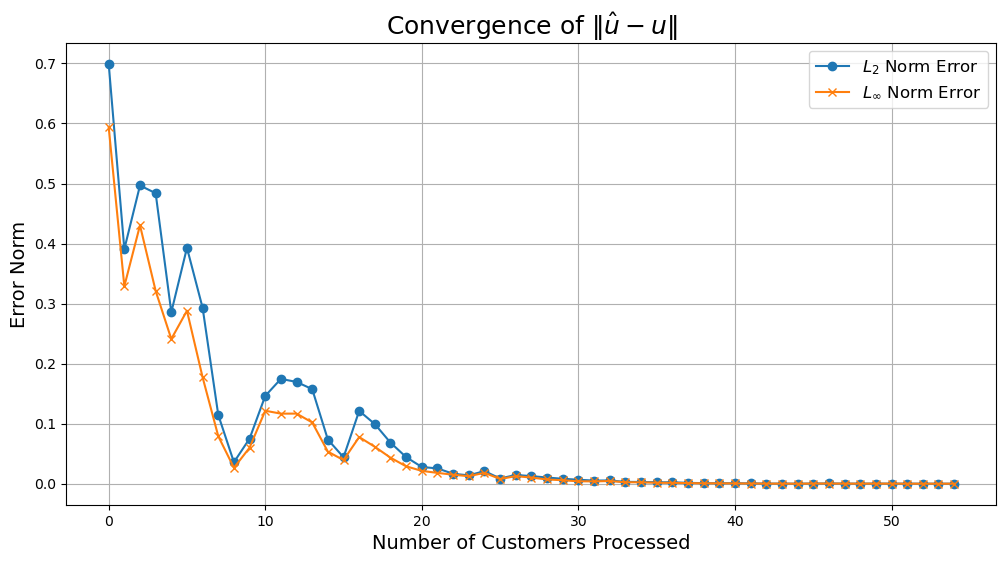

In [22]:
simulator.utility_updates

# plot L2, and L-inf norms of utility updates
L2_errors = [np.linalg.norm(update['u_hat'] - UTILITY_TRUE) for update in simulator.utility_updates]
Linf_errors = [np.linalg.norm(update['u_hat'] - UTILITY_TRUE, ord=np.inf) for update in simulator.utility_updates]

plt.figure(figsize=(12, 6))
plt.plot(L2_errors, label='$L_2$ Norm Error', marker='o')
plt.plot(Linf_errors, label='$L_\infty$ Norm Error', marker='x')
# plt.yscale('log')
plt.xlabel('Number of Customers Processed', fontsize=14)
plt.ylabel('Error Norm', fontsize=14)

plt.title('Convergence of $\|\hat u - u\|$', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('figures/utility_convergence.pdf')
plt.show()

INFO:root:Starting simulation for 20000 customers...
  0%|          | 46/20000 [18:14<210:55:14, 38.05s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 47: Diameter: 0.0005
  0%|          | 49/20000 [20:16<219:48:10, 39.66s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 50: Diameter: 0.0001
  0%|          | 51/20000 [21:38<223:02:15, 40.25s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 52: Diameter: 0.0002
  0%|          | 52/20000 [22:20<225:50:51, 40.76s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 53: Diameter: 0.0002
  0%|          | 53/20000 [23:03<230:37:33, 41.62s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 54: Diameter: 0.0002
  0%|          | 54/20000 [23:47<234:41:12, 42.36s/it]WARNING:root:Degenerate step in hit-and-run; skipping sample.
INFO:root:Customer 55: Diameter: 0.0001
  0%|      

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  1.09861D+00    |proj g|=  7.51808D-01

At iterate    1    f=  5.26910D-01    |proj g|=  2.67514D-01

At iterate    2    f=  3.05592D-01    |proj g|=  4.82350D-02

At iterate    3    f=  3.00394D-01    |proj g|=  3.39379D-02

At iterate    4    f=  2.94887D-01    |proj g|=  3.42631D-03

At iterate    5    f=  2.94825D-01    |proj g|=  2.75754D-04

At iterate    6    f=  2.94824D-01    |proj g|=  2.46829D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

  0%|          | 55/20000 [24:41<149:14:27, 26.94s/it]


KeyboardInterrupt: 

## Training policy under perfect information

In [25]:
class PerfectDegradationLearner:
    def __init__(self, d, theta_true, hazard_model):
        self.d = d
        self.theta_true = theta_true
        self.hazard_model = hazard_model  # Placeholder, not used
        
    def get_theta(self):
        return self.theta_true
    
    def cum_baseline(self, t):
        return self.hazard_model.Lambda_0(t)
    
    def inverse_cum_baseline(self, u):
        return self.hazard_model.Lambda_0_inverse(u)
    
perfect_degradation_learner = PerfectDegradationLearner(
    d=D, 
    theta_true=THETA_TRUE,
    hazard_model=usage_exp_hazard_model,
)

perfect_dpagent = DPAgent(
    d=D,
    u_hat=UTILITY_TRUE,
    time_normalize=True,
    degradation_learner=perfect_degradation_learner,
    customer_generator=customer_gen,
    params=mdp_params,
)

# weight = torch.load('weights/perfect_dpagent_q_network.pth', map_location=torch.device('cuda'))
# perfect_dpagent.q_network.load_state_dict(weight)
# perfect_dpagent.q_network.to(perfect_dpagent.device)
# perfect_dpagent.q_network.eval()
perfect_dpagent.train(
    num_iterations=50,
    dataset_size=500000,
    batch_size=1024
)

perfect_policy = perfect_dpagent.get_policy(
    {'type': 'greedy', 'epsilon': 0.1, 'tau': 1.0}
)

Using device: cuda
Generating 500000 experience samples...


100%|██████████| 500000/500000 [00:08<00:00, 59906.04it/s]



Starting FQI training loop...


  0%|          | 0/50 [00:59<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
num_repeat = 10
histories = []

for _ in range(num_repeat):
    history = simulator.run_full_exploit(10000, policy)
    history = pd.DataFrame(history)
    
    history['net_profit'] = history['profit'] + history['loss']
    # calculate cumulative profit and loss
    history['cumulative_net_profit'] = history['net_profit'].cumsum()
    histories.append(history)


In [ ]:
ax = plt.figure(figsize=(10,6))

# plot cumulative profit and loss over time
plt.plot(history['calendar_time'], history['cumulative_net_profit'], label='Cumulative Net Profit')
plt.xlabel('Calendar Time')
plt.ylabel('Cumulative Net Profit')
plt.title('Cumulative Net Profit Over Time')
plt.legend()
plt.grid()
plt.show()

### Debugging: Look at experience dataset

In [ ]:
from policy import DPAgent

print(simulator.projected_volume_learner.get_estimate())
print(UTILITY_TRUE)

dp_agent = DPAgent(
    d=simulator.d,
    u_hat=simulator.projected_volume_learner.get_estimate(),
    time_normalize=simulator.time_normalize,
    degradation_learner=simulator.degradation_learner,
    customer_generator=simulator.customer_generator,
    params=simulator.mdp_params
)

dataset = dp_agent.experience_generator.generate(500)

for data in dataset:
    state, action, reward, next_state = data
    print("State:", state.round(3))
    print("Action:", dp_agent.experience_generator.ACTION_MAP[action])
    print("Reward:", reward)
    print("Next State:", next_state.round(3))
    print("-----")
    print()

In [ ]:
degradation_learner = DegradationLearner(d=D, initial_theta=np.zeros(D))
degradation_df = pd.DataFrame(simulator.degradation_history)
degradation_learner.fit(degradation_df)
degradation_learner.get_theta()

Testing Policy

In [ ]:
i = 50

X_i = df.loc[i, 'sum_of_contexts_after']
I_i = 3 # df.loc[i, '']
x_i = df.loc[i+1, 'customer_context']
T_i = df.loc[i+1, 'rental_duration']

arrival_state = np.concatenate([
    X_i,
    x_i,
    [T_i, I_i, 0.0]
])
action_arrival = optimal_policy(arrival_state)
action_map = {0: 'Give Max Acceptable Price', 1: 'Shutdown'}
print(f"Sample Arrival State. Optimal Action: {action_map[action_arrival]}")


In [ ]:
# Test Case 2: Departure State
departure_state = np.concatenate([
    X_i+x_i*10, 
    np.zeros(D), 
    [0.0, I_i, 1.0]
])
action_departure = optimal_policy(departure_state)
action_map = {2: 'Replace Machine', 3: 'Do Not Replace'}
print(f"Sample Departure State. Optimal Action: {action_map[action_departure]}")
